In [4]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import visdom

import numpy as np
import matplotlib.pyplot as plt

import cv2
import glob
import random

import progressbar  # https://github.com/JohnYKiyo/Noise2Void/tree/master/src/utils

## 1. Dataset

In [5]:
def normalize(x):
    return x.div(255)

def denormalize(x):
    return np.clip(x.mul(255),0,255).type(torch.int)

In [6]:
class Noise2VoidDataset(Dataset):
    
    def __init__(self, pic, virtural_datasize=1000, crop_size=None, gauss_std=1, transform=None, valid=False):
        super(Noise2VoidDataset, self).__init__()
        self.img = cv2.cvtColor(cv2.imread(pic), cv2.COLOR_BGR2RGB)  # 원본 이미지(noise x)
        self.crop_size = crop_size
        self.noise_std = gauss_std
        self.transform = transform
        self.valid = valid
        
        self.noised_img = self._add_noise(self.img)  # noise 추가
        self.noised_imgs =[]
        
        # Test/Valid용인 경우
        if valid:
            self.origin_imgs = []  # noise가 없는 원본 이미지
            
        for i in range(virtural_datasize):
            # Crop o
            if crop_size is not None:
                cropped_noisy_img, cropped_origin_img = self._random_crop([self.noised_img, self.img])
            # Crop x    
            else:
                cropped_noisy_img, cropped_origin_img = self.noised_img, self.img
            self.noised_imgs.append(cropped_noisy_img)
            
            # Test/Val인 경우
            if valid:
                self.origin_imgs.append(cropped_origin_img)

    def __getitem__(self, index):
        source = self.noised_imgs[index]
        source = torch.tensor(source, dtype=torch.float)
        
        # blind spot이 있는 noise 이미지, noise 이미지, blind spot masking 행렬 반환 (Train인 경우)
        source, target, blind_pos = self._mask_pixel(source)  
        
        # Test/Val인 경우 target 이미지는 noise 이미지가 아닌 원본 이미지
        if self.valid:
            target =  torch.tensor(self.origin_imgs[index], dtype=torch.float)
        
        if self.transform:
            source = self.transform(source)
            target = self.transform(target)
        
        return source.permute(2, 0, 1), target.permute(2, 0, 1), torch.tensor(blind_pos)

    def __len__(self):
        return len(self.noised_imgs)

    def _add_noise(self, img):
        h, w, c = img.shape
        Noise = np.random.normal(0, self.noise_std, (h, w, c))  # zero mean noise
        noise_img = np.clip(img + Noise, 0, 255).astype(np.uint8)  # noise를 더하는 과정에서 픽셀이 0미만, 255초과의 값을 갖지 않도록

        return noise_img

    def _mask_pixel(self, img):  
        '''
        a randomly selected pixel is chosen and its intensity copied over to create a blind-spot.
        input : img - noise가 추가된 이미지 (source)
        output  
         - source : blind spot masking이 적용된 이미지 (학습용)
         - target : noise가 추가된 이미지
         - [blind_spot_i, blind_spot_j] : blind spot masking 행렬
        '''
        h, w, _ = img.shape

        random_select_pixel_i = np.random.randint(0, h)
        blind_spot_i = np.random.randint(0, h)
        while blind_spot_i == random_select_pixel_i:
            blind_spot_i = np.random.randint(0, h)
        
        random_select_pixel_j = np.random.randint(0, w)    
        blind_spot_j = np.random.randint(0, w)
        while blind_spot_j == random_select_pixel_j:
            blind_spot_j = np.random.randint(0, w)
            
        target = img.clone()
        source = img.clone()
        
        # 랜덤하게 선택된 blind_spot위치의 픽셀을 랜덤하게 다른 값으로 변경함 (BERT의 masked language model과 유사)
        source[blind_spot_i, blind_spot_j, :] = img[random_select_pixel_i, random_select_pixel_j, :]

        return source, target, [blind_spot_i, blind_spot_j]

    def _random_crop(self, imgs):
        h, w, _  = imgs[0].shape
        assert w >= self.crop_size and h >= self.crop_size, 'Error: Crop size:{self.crop_size} is learger than Image size: ({w},{h})'
        i = np.random.randint(0, h - self.crop_size +1)
        j = np.random.randint(0, w - self.crop_size +1)
        return self._crop(imgs[0], i, j, self.crop_size, self.crop_size), self._crop(imgs[1], i, j, self.crop_size, self.crop_size) 
        
    def _crop(self,img, i, j, h, w):
        """Crop the given image.
        Args:
            img (numpy array): Image to be cropped.
            i (int): i in (i,j) i.e coordinates of the upper left corner.
            j (int): j in (i,j) i.e coordinates of the upper left corner.
            h (int): Height of the cropped image.
            w (int): Width of the cropped image.
        Returns:
            Image: Cropped image.
        """
        return img[i:i+h,j:j+w,:]

In [8]:
def _mask_pixel(img):  
    '''
        a randomly selected pixel is chosen and its intensity copied over to create a blind-spot.
        input : img - noise가 추가된 이미지 (source)
        output  
         - source : blind spot masking이 적용된 이미지 (학습용)
         - target : noise가 추가된 이미지
         - [blind_spot_i, blind_spot_j] : blind spot masking행렬
    '''
    h, w, _ = img.shape

    random_select_pixel_i = np.random.randint(0, h)
    blind_spot_i = np.random.randint(0, h)
    while blind_spot_i == random_select_pixel_i:
        blind_spot_i = np.random.randint(0, h)
        
    random_select_pixel_j = np.random.randint(0, w)    
    blind_spot_j = np.random.randint(0, w)
    while blind_spot_j == random_select_pixel_j:
        blind_spot_j = np.random.randint(0, w)
            
    target = img.copy()
    source = img.copy()
        
    # 랜덤하게 선택된 blind_spot위치의 픽셀을 랜덤하게 다른 값으로 변경함
    source[blind_spot_i, blind_spot_j, :] = img[random_select_pixel_i, random_select_pixel_j, :]

    return source, target, [blind_spot_i, blind_spot_j]

In [28]:
img = cv2.cvtColor(cv2.imread('C:/Users/Moon/Desktop/bear.jpg'), cv2.COLOR_BGR2RGB)
source, target, blind_pos = _mask_pixel(img)

In [29]:
blind_pos  # blind spot의 픽셀 위치

[234, 112]

In [32]:
# blind spot위치에 해당하는 픽셀 값 비교
# source의 경우 랜던하게 다른 값으로 변경되었기 때문에 target과 픽셀 값이 다른 것에 주목
# target의 픽셀값이 복원해야 하는 값 (일종의 ground truth)
print(source[234, 112, :])  
print(target[234, 112, :])

[16 18 15]
[226 211 152]


In [ ]:
plt.imshow(source)

## 2. Model

In [10]:
# Encoder용 block (down-path)
class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        
        return out

In [11]:
# Decoder용 block (up-path)
class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
            
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2,align_corners=True),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )
            
        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])]

    def forward(self, x, bridge):  
        '''x : 이전 UpBlock의 출력
           bridge : x와 크기가 같은 Encoder 출력'''
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])  
        # Concat
        out = torch.cat([up, crop1], 1)  
        out = self.conv_block(out)

        return out

In [12]:
class UNet(nn.Module):

    def __init__(self, 
        in_channels=1, 
        out_channels=2, 
        depth=5, 
        n_filters_at_firstlayer=6, 
        padding=False, 
        batch_norm=False, 
        up_mode='upconv',):

        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation(Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Args:
            in_channels (int): number of input channels
            out_channels (int): number of output channels
            depth (int): depth of the network
            n_filters_at_firstlayer (int): number of filters in the first layer is 2**n_filters_at_firstlayer
                default is 6 => 2**6 = 64
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                                activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                            'upconv' will use transposed convolutions for
                            learned upsampling.
                            'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()

        assert up_mode in ('upconv', 'upsample')

        self.padding = padding
        self.depth = depth
        prev_channels = in_channels

        # Encoder (make down sample layers)
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (n_filters_at_firstlayer + i), padding, batch_norm)
            )
            prev_channels = 2 ** (n_filters_at_firstlayer + i)  # 채널이 2배씩 증가
		
        # Decoder (make up sample layers)
        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (n_filters_at_firstlayer + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (n_filters_at_firstlayer + i)  # 채널이 2배씩 감소
		
        self.last = nn.Conv2d(prev_channels, out_channels, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])  # encoder의 마지막 block부터 차례대로 concat됨

        return self.last(x)

In [14]:
x = torch.randn([1, 3, 640, 586])
model = UNet(3, 3, depth=4, batch_norm=True, up_mode='upsample', padding=True)
out = model(x)

print(out.shape)

torch.Size([1, 3, 640, 584])


## 3. Train

In [15]:
def pixel_mse_loss(predictions, targets, pixel_pos):
    mask = torch.zeros(targets.shape).to(targets.device)
    for i, (h, w) in enumerate(pixel_pos):
        mask[i, :, h, w] = 1.  # blind_spot에 해당하는 픽셀만 1, 나머지는 0

    # blind spot에 해당하는 픽셀들에 대해서만 loss가 계산됨     
    return F.mse_loss(predictions * mask, targets * mask) * 1000

In [16]:
def save_model_parameters(model,savedir, loss, loss_min, epoch,save_per_epoch=True):
    if not os.path.exists(savedir):
        os.makedirs(savedir)      
            
    try:
        state_dict = model.module.state_dict()
        
    except AttributeError:
        state_dict = model.state_dict()
    
    # 가중치 저장
    if (epoch == 0) or (loss_min > loss):
        loss_min = loss
        torch.save(state_dict, os.path.join(savedir,'best.pth'))
    if save_per_epoch:
        torch.save(state_dict, os.path.join(savedir,'epoch{0}.pth'.format(epoch)))
    
    return loss_min
    
def visualize_losses(losses, epoch, legends, title, window_name,env_name):
    viz = visdom.Visdom(env=env_name)
    viz.line(X=[epoch],Y=[losses[-1]],opts=dict(legend=legends, title=title), win=window_name, update='append')

In [17]:
def train_per_epoch(train_loader, model, optimizer, loss_function):
    model.train()
    
    N_batch = len(train_loader)
    running_loss = []
    prob_tr = progressbar.progbar(N_batch,display='notebook',clear_display=False)
    for batch_idx,(sources,targets,pixel_pos) in enumerate(train_loader):
        if torch.cuda.is_available():
            sources,targets = sources.to('cuda'), targets.to('cuda')
            
        predicts = model(sources)
        loss = loss_function(predicts, targets,pixel_pos)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
        
        if (batch_idx%10 == 0) or (batch_idx==0) or (batch_idx==N_batch-1):
            prob_tr.update(
                batch_idx,
                info='train batch:{0}/{1}, loss:{2}'.format(batch_idx,N_batch,loss.item()))
    del prob_tr
    
    return np.mean(running_loss)    

In [24]:
def valid_per_epoch(valid_loader, model, loss_function):
    model.eval()
    
    running_loss = []
    prob_vl = progressbar.progbar(len(valid_loader), display='notebook', clear_display=False)
    with torch.no_grad():
        for batch_idx, (sources, targets, pixel_pos) in enumerate(valid_loader):
            if torch.cuda.is_available():
                sources, targets = sources.to('cuda'), targets.to('cuda')
            
            predicts = model(sources)
            loss = loss_function(predicts, targets, pixel_pos)
            
            running_loss.append(loss.item())
            if (batch_idx%20 == 0) or (batch_idx==0) or (batch_idx==len(valid_loader)-1):
                prob_vl.update(
                    batch_idx,
                    info='train batch:{0}/{1}, loss:{2}'.format(batch_idx,len(valid_loader),loss.item()))
    del prob_vl
    
    return np.mean(running_loss) 

In [25]:
def train():
    model = UNet(3, 3, depth=4, batch_norm=True, up_mode='upsample', padding=True)  # in_channels=out_channels=3
    if torch.cuda.is_available():
        model = nn.DataParallel(model)
        model = model.to('cuda')

    # dataset (single image)
    # 검증용 data의 경우 valid=True 옵션 지정 (default: False)
    noised_dataset = Noise2VoidDataset(pic='C:/Users/Moon/Downloads/Noise2Void-master/Noise2Void-master/train/000000000632.jpg', virtural_datasize=10000, crop_size=64, gauss_std=50, transform=normalize)
    train_loader = DataLoader(noised_dataset, batch_size=100, shuffle=True, num_workers=0)
    valid_dataset = Noise2VoidDataset(pic='C:/Users/Moon/Downloads/Noise2Void-master/Noise2Void-master/train/000000000632.jpg', virtural_datasize=100, crop_size=64, gauss_std=50, transform=normalize,valid=True)
    valid_loader = DataLoader(valid_dataset, batch_size=20, shuffle=True, num_workers=0)
    
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    N_epoch = 50
    loss_history = []
    loss_min = np.inf

    prog = progressbar.progbar(N_epoch,display='notebook', clear_display=True)
    for epoch in range(N_epoch):
        loss_train = train_per_epoch(train_loader, model, optimizer, loss_function=pixel_mse_loss)
        loss_valid = valid_per_epoch(valid_loader, model, loss_function=pixel_mse_loss)

        loss_history.append([loss_train, loss_valid])    
        loss_min = save_model_parameters(
            model,
            savedir='./stored/Noise2Void/',
            loss=loss_valid,
            loss_min=loss_min,
            epoch=epoch,
            save_per_epoch=True)
        
        visualize_losses(
            losses=np.array(loss_history),
            epoch=epoch, 
            legends=['train', 'valid'], 
            title='Noise2Noise',
            window_name='Noise2Void', 
            env_name='Noise2Void')
        
        prog.update(epoch)

    del prog

In [26]:
train()

'    100% |################################| 0day  0:00:00 Total time: 0day  0:27:15'

## 4. Test

In [33]:
model = UNet(3, 3, depth=4, batch_norm=True, up_mode='upsample', padding=True)
if torch.cuda.is_available():
    model = model.to('cuda')
    
# 최적 가중치 load        
model.load_state_dict(torch.load('./stored/Noise2Void/best.pth'))
model.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): C

In [34]:
# 학습에 사용된 동일한 single image사용 (valid=True 옵션 지정)
eval_dataset = Noise2VoidDataset(pic='C:/Users/Moon/Downloads/Noise2Void-master/Noise2Void-master/train/000000000632.jpg', virtural_datasize=100,crop_size=None, gauss_std=50,transform=normalize,valid=True)

In [35]:
# blind spot이 있는 noise 이미지 / 원본 이미지 (noise x) / masking 행렬
source, target, pos = eval_dataset[0]

In [36]:
with torch.no_grad():
    predict = model(source.unsqueeze(0).to('cuda')).to('cpu').squeeze()

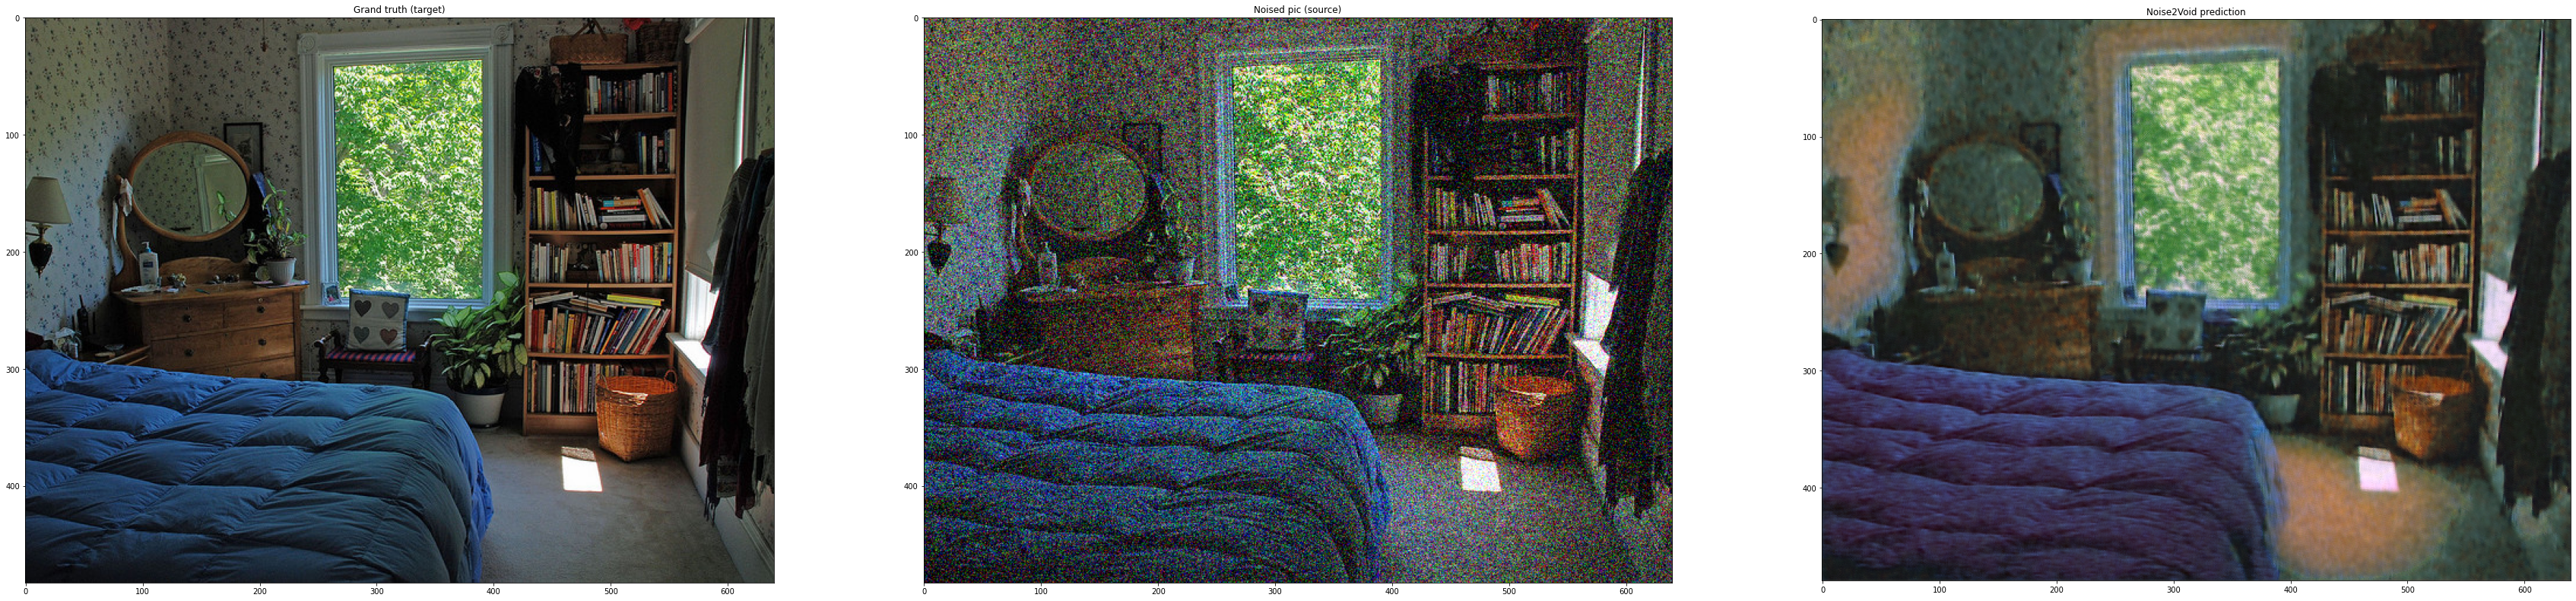

In [37]:
plt.figure(figsize=[60, 20])

plt.subplot(1, 3, 1)
plt.title('Grand truth (target)')
plt.imshow(denormalize(target.permute(1, 2, 0)))

plt.subplot(1, 3, 2)
plt.title('Noised pic (source)')
plt.imshow(denormalize(source.permute(1, 2, 0)))

plt.subplot(1, 3, 3)
plt.title('Noise2Void prediction')
plt.imshow(denormalize(predict.permute(1, 2, 0)))
plt.show()